## Random Forest and Gradient Boosting Machine Models on the cement dataset

Initially, I am going to work on training individual decision trees on the cement dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Concrete+Slump+Test).

This dataset is a collection of measurements of compositional properties of concrete and their effect on the concrete's durability.

The dataset is composed of 7 input measurement features (kilograms per meter cubed of concrete):
  * Cement
  * Slag	
  * Fly ash	
  * Water	
  * SP	
  * Coarse Aggr.	
  * Fine Aggr.
  
And 3 output measurements:
  * SLUMP (cm)	
  * FLOW (cm)	
  * 28-day Compressive Strength (Mpa)

In [36]:
# Importing required packages

#data handling/prediction
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.externals.six import StringIO

#visualization
%matplotlib inline
import seaborn as sns
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz

In [37]:
# Downloading data from the web

cement_data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/slump/slump_test.data",index_col=0)
#replace spaces and periods in column names with underscores
cement_data.columns = cement_data.columns.str.lower()\
                                         .str.replace(" ","_")\
                                         .str.replace(".","")\
                                         .str.replace("(","_")\
                                         .str.replace(")","_")

In [38]:
#Looking at the data
cement_data.head()

,cement,slag,fly_ash,water,sp,coarse_aggr,fine_aggr,slump_cm_,flow_cm_,compressive_strength__28-day__mpa_
No,,,,,,,,,,
1,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
2,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14
3,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81
4,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08
5,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82


In [39]:
#Number of rows and columns in data

cement_data.shape

(103, 10)

In [40]:
#We need to predict the last column (compressive_strength) from the seven input columns

#First, we can do some exploratory data analysis using seaborn. For this purpose, we can map the output column into 5 colours

X,y = cement_data.iloc[:,:7],cement_data.iloc[:,-1]
feature_names_cem = X.columns.tolist()
target_name = cement_data.columns.tolist()[-1]
cement_data["compressive_strength_bins"] = pd.cut(cement_data[target_name],5) #create 5 equally-sized bins




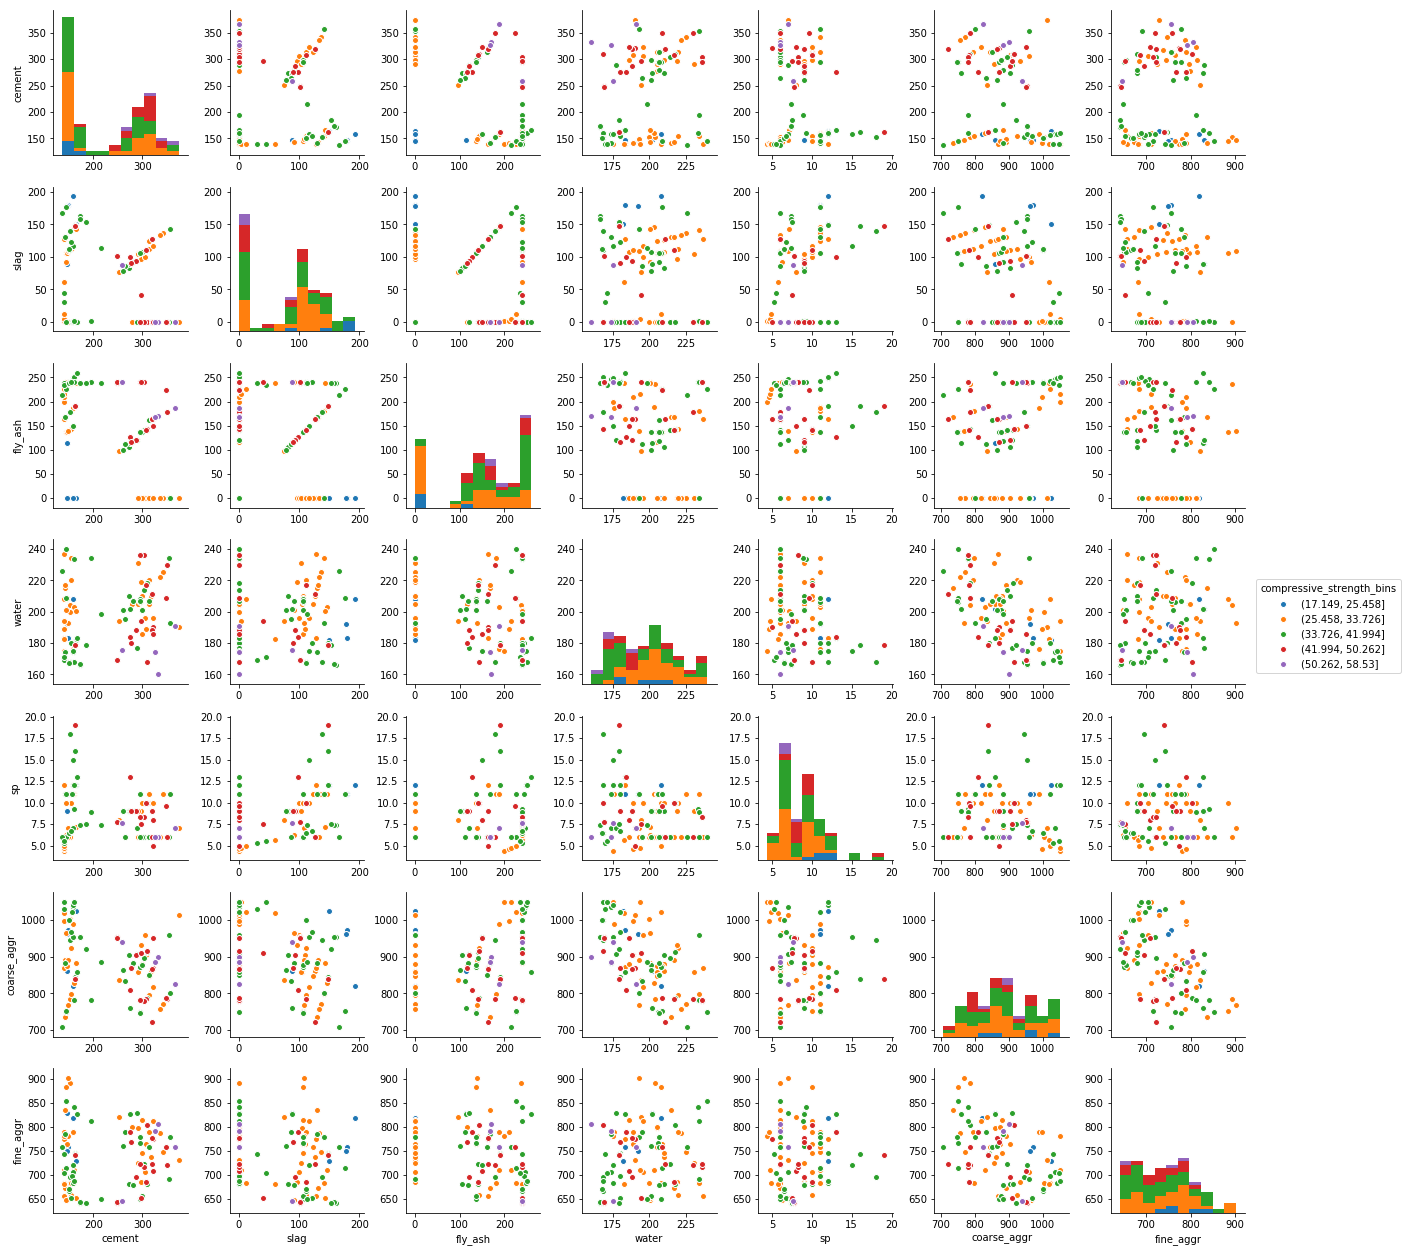

In [41]:
#'compressive_strength_bins' will be used as the hue for a scatter matrix in seaborn

sns.pairplot(cement_data[feature_names_cem+['compressive_strength_bins']], hue ='compressive_strength_bins')

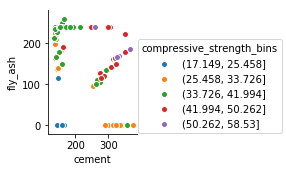

In [28]:
#'cement' and fly ash look seperable in terms of those bins.

sns.pairplot(cement_data, x_vars= ['cement'], y_vars= ['fly_ash'], hue = 'compressive_strength_bins')

In [42]:
#We can build a simple decision tree classifier using these two features

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3,
                                                 random_state=20)

decision_tree = DecisionTreeRegressor(max_depth=2)
decision_tree.fit(X_train,y_train)
print("Decision Tree RMSE:",np.sqrt(mean_squared_error(y_test,decision_tree.predict(X_test))))

Decision Tree RMSE: 5.65887429481


Decision Tree Train/Test RMSE: 6.33729731212   7.6148017733
Decision Tree Train/Test RMSE: 4.09363131826   5.65887429481
Decision Tree Train/Test RMSE: 3.15128296237   4.85271627142
Decision Tree Train/Test RMSE: 2.22028264867   4.42904722634
Decision Tree Train/Test RMSE: 1.27044694208   4.79273910246
Decision Tree Train/Test RMSE: 0.734274544801   4.69860498136
Decision Tree Train/Test RMSE: 0.300420423   4.06621691557
Decision Tree Train/Test RMSE: 0.153411061217   4.94802763826
Decision Tree Train/Test RMSE: 0.0791973624701   4.35617026238
Decision Tree Train/Test RMSE: 0.0   4.04280444023


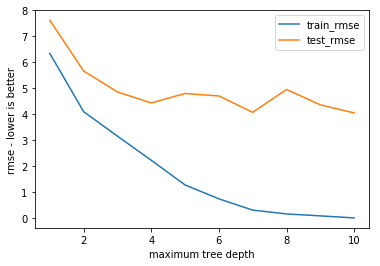

In [43]:
#We can measure testing error as we add depth to this simple tree

depths = range(1,11)
train_rmse, test_rmse = [],[]
for depth in depths:
    decision_tree = DecisionTreeRegressor(max_depth=depth,random_state=10)
    decision_tree.fit(X_train,y_train)
    curr_train_rmse = np.sqrt(mean_squared_error(y_train,decision_tree.predict(X_train)))
    curr_test_rmse = np.sqrt(mean_squared_error(y_test,decision_tree.predict(X_test)))
    print("Decision Tree Train/Test RMSE:",curr_train_rmse," ",curr_test_rmse)
    train_rmse.append(curr_train_rmse)
    test_rmse.append(curr_test_rmse)
sns.mpl.pyplot.plot(depths,train_rmse,label='train_rmse')
sns.mpl.pyplot.plot(depths,test_rmse,label='test_rmse')
sns.mpl.pyplot.xlabel("maximum tree depth")
sns.mpl.pyplot.ylabel("rmse - lower is better")
sns.mpl.pyplot.legend()

In [44]:
#From the above we can see that the training error goes down as depth increases because of overfitting but the lowest test error occurs at a depth of 3
best_single_tree = DecisionTreeRegressor(max_depth=3, random_state=1)
best_single_tree.fit(X_train, y_train)

best_single_tree.feature_importances_

array([ 0.31643826,  0.01772542,  0.56265554,  0.10318079,  0.        ,
        0.        ,  0.        ])

## Evaluating Feature Importance

In [45]:
pd.DataFrame({'feature':cement_data.columns.tolist()[:7], 'importance':best_single_tree.feature_importances_})

,feature,importance
0,cement,0.316438
1,slag,0.017725
2,fly_ash,0.562656
3,water,0.103181
4,sp,0.000000
5,coarse_aggr,0.000000
6,fine_aggr,0.000000


In [47]:
#Making predictions on the test data and computing RMSE
y_pred = best_single_tree.predict(X_test)
np.unique(y_pred)
# calculate test set RMSE
np.sqrt(mean_squared_error(y_test, y_pred))

4.8527162714224827

In [62]:
#We can write a bagging function manually to improve the RMSE

# set a seed for reproducibility
np.random.seed(1234)

# create ten bootstrap samples (will be used to select rows from the DataFrame)

samples = [np.random.choice(a=X_train.shape[0], size=X_train.shape[0], replace=True) for _ in range(1, 11)]
samples

[array([47, 38, 53, 24, 15, 49, 23, 26, 30, 43, 30, 26, 58, 69, 47, 50, 37,
        34, 38, 67, 11,  0,  3,  2, 19, 12, 65, 14, 71, 60, 46, 28, 13, 12,
        69, 31, 45, 16, 41, 56, 70, 56, 44, 47, 49, 18, 46, 37, 38,  7, 67,
         5, 47, 47, 15, 34, 10, 28,  4, 55, 23, 50, 62, 55,  0, 33, 21, 71,
        68, 52, 64, 41]),
 array([ 1, 14,  3, 30, 12, 19, 26, 68, 64, 22, 56,  8, 44, 24, 15,  2, 16,
         2, 67, 46, 57, 55, 36, 33, 42,  2, 35, 18, 69,  8, 15, 20, 16, 64,
        61, 57, 49, 62, 57, 27, 35, 36, 61, 28,  1, 11, 62, 17, 30, 38, 25,
        56, 24, 12,  8, 47, 25, 21, 22, 45, 19, 41, 47, 36, 39, 17, 39, 59,
        37, 38,  8, 54]),
 array([17, 41, 47, 19, 43, 44, 35, 42, 20, 26, 23,  2, 65, 27, 68, 60,  3,
        47, 61, 63, 32, 13, 56, 48, 58, 35, 57, 60,  9, 60, 50, 51, 49, 71,
         4,  3, 46, 47, 63,  5, 63, 56, 14, 60,  8, 41, 33, 69, 63, 17,  1,
         1,  2, 51, 52, 14, 47, 65, 29,  9, 50, 17, 31, 11, 34, 53, 24, 55,
        53, 23, 58, 16]),
 array([ 6

In [63]:
X = cement_data[cement_data.columns.tolist()[:7]]
y = cement_data['compressive_strength__28-day__mpa_']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,
                                                 random_state=1)

# grow each tree deep
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# list for storing predicted compressive strength from each tree
predictions = []

# define testing data
X_test_boot = X_test
y_test_boot = y_test

# grow one tree for each bootstrap sample and make predictions on testing data
for sample in samples:
    X_train_boot = X_train.iloc[sample, :]
    y_train_boot = y_train.iloc[sample]
    treereg.fit(X_train_boot, y_train_boot)
    y_pred_boot = treereg.predict(X_test_boot)
    predictions.append(y_pred_boot)

# convert predictions from list to NumPy array
predictions = np.array(predictions)
predictions

array([[ 29.77,  17.19,  34.05,  31.37,  37.39,  34.05,  29.63,  44.48,
         34.05,  37.39,  49.17,  18.26,  50.23,  49.3 ,  38.46,  49.17,
         37.39,  49.17,  41.27,  34.45,  38.46,  18.26,  49.17,  37.39,
         28.7 ,  38.19,  17.19,  34.05,  30.43,  30.43,  42.08],
       [ 31.77,  34.45,  32.57,  29.77,  38.46,  33.78,  36.46,  30.83,
         32.57,  43.01,  42.08,  30.83,  41.81,  52.65,  41.01,  42.08,
         37.39,  52.65,  38.46,  39.13,  42.08,  30.83,  32.71,  34.99,
         30.97,  33.78,  17.19,  33.78,  49.3 ,  28.7 ,  42.08],
       [ 29.63,  33.51,  35.52,  28.16,  46.36,  37.92,  28.16,  35.52,
         35.52,  49.3 ,  50.5 ,  30.43,  43.01,  49.3 ,  45.82,  50.23,
         43.01,  50.23,  41.27,  41.27,  46.36,  30.43,  26.42,  41.27,
         30.97,  38.19,  17.19,  37.92,  43.01,  26.42,  42.08],
       [ 29.23,  33.51,  34.05,  31.77,  46.36,  37.92,  28.16,  33.78,
         34.05,  45.82,  50.23,  30.83,  41.27,  52.65,  45.69,  50.23,
         34.1

In [64]:
# average the predictions
np.mean(predictions, axis=0)

array([ 30.086,  31.009,  33.979,  31.666,  45.181,  34.553,  32.924,
        32.922,  34.221,  42.89 ,  46.931,  28.866,  45.164,  51.284,
        45.355,  43.68 ,  34.808,  44.777,  41.794,  38.262,  45.529,
        29.616,  34.931,  37.151,  30.971,  35.222,  22.125,  36.36 ,
        42.569,  29.43 ,  41.838])

In [65]:
# calculate RMSE for bagged regression trees
y_pred_boot = np.mean(predictions, axis=0)
print("Bagged RMSE:",np.sqrt(mean_squared_error(y_test_boot, y_pred_boot)))

#calculate RMSE for single decision tree with same exact parameters as each tree in the bag
single_tree = DecisionTreeRegressor(max_depth=None, random_state=123)
single_tree.fit(X_train,y_train)
y_pred_single = single_tree.predict(X_test)
print("Single Tree RMSE:",np.sqrt(mean_squared_error(y_test_boot, y_pred_single)))

Bagged RMSE: 3.18956598322
Single Tree RMSE: 3.95672600077


In [66]:
#We see an improvement in the RMSE in the case when bagging is used

In [69]:
#Implementing the above using scikitlearn. 1000 trees are used in the below simulation

bagreg = BaggingRegressor(DecisionTreeRegressor(),
                          n_estimators=500, bootstrap=True, oob_score=True, random_state=1)
# fit and predict
bagreg.fit(X_train, y_train)
y_pred_bag = bagreg.predict(X_test)
y_pred_bag

print("Bagged RMSE with 500 trees:",np.sqrt(mean_squared_error(y_test, y_pred_bag)))
print("OOB error is: ", bagreg.oob_score_)

Bagged RMSE with 500 trees: 3.20913522778
OOB error is:  0.756361600554


Clearly, the performance of the bagged regressor on the test set is better than a single decision tree regressor since the RMSE is lower in the former case. I am not going to train a RandomForest model to this data to bring down the RMSE further

In [71]:
#Random forest of 500 trees
rf = RandomForestRegressor(n_estimators=500, bootstrap=True, oob_score=True, random_state=12)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest RMSE:",np.sqrt(mean_squared_error(y_test,y_pred_rf)))

Random Forest RMSE: 3.14956779803


In [72]:
#Comparing the three models
print("Single Tree RMSE:",np.sqrt(mean_squared_error(y_test_boot, y_pred_single)))
print("Bagged RMSE with 500 trees:",np.sqrt(mean_squared_error(y_test, y_pred_bag)))
print("Random Forest RMSE:",np.sqrt(mean_squared_error(y_test,y_pred_rf)))

Single Tree RMSE: 3.95672600077
Bagged RMSE with 500 trees: 3.20913522778
Random Forest RMSE: 3.14956779803


Clearly, the Random Forest Regressor model has the best performance among all the tree models yet. We can tune the random forest to improve performance further

### Tuning Random Forests: # of trees and maximum features used using GridSearchCV

In [74]:
from sklearn.model_selection import GridSearchCV
paramgrid = {'n_estimators': range(20, 500, 20), 'max_features':range(1, len(feature_names_cem)+1)}

rf_tune = RandomForestRegressor()

CV = GridSearchCV(rf_tune, param_grid = paramgrid, n_jobs = -1)

CV.fit(X_train,y_train)





GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': range(20, 500, 20), 'max_features': range(1, 8)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [79]:
best_param_n_est = CV.best_estimator_.n_estimators
best_param_max_features = CV.best_estimator_.max_features

print("The best parameter for the number of estimators is {} and max number of features at each split is {}".format(best_param_n_est,best_param_max_features))


The best parameter for the number of estimators is 40 and max number of features at each split is 5


In [80]:
rfreg_best = RandomForestRegressor(n_estimators=40, max_features=5, bootstrap=True, oob_score=True, random_state=123)
rfreg_best.fit(X_train,y_train)
preds = rfreg_best.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,preds))
print("Best RMSE:",rmse)

Best RMSE: 3.18534036485


In [81]:
# compute feature importances
pd.DataFrame({'feature':feature_names_cem, 
              'importance':rfreg_best.feature_importances_}).sort_values(by='importance',ascending=False)

,feature,importance
0,cement,0.327696
2,fly_ash,0.303539
3,water,0.134277
1,slag,0.090662
5,coarse_aggr,0.073368
6,fine_aggr,0.053900
4,sp,0.016559


Finally, I fit a Gradient Boosting Model to this dataset to see if the RMSE can be reduced further

In [87]:
from sklearn.model_selection import cross_val_score
n_trees_range = np.arange(10,110,10)
learn_rates_range = np.arange(0.1,1.1,0.1)
param_grid = {"n_estimators":n_trees_range,"learning_rate":learn_rates_range}
gb_reg = GradientBoostingRegressor(max_depth=3)

gs = GridSearchCV(gb_reg,
                  param_grid,
                  n_jobs=-1)

gs.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]), 'learning_rate': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

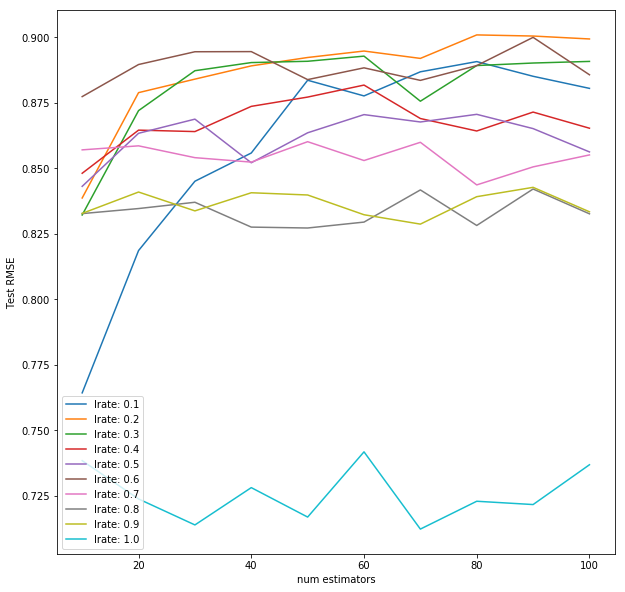

In [88]:
scores = [np.sqrt(np.abs(x)) for x in gs.cv_results_["mean_test_score"]]
scores = np.array(scores).reshape(len(n_trees_range), len(learn_rates_range))

fig = sns.mpl.pyplot.figure(figsize=(10,10))
fig.add_subplot(111)
for ind, i in enumerate(learn_rates_range):
    sns.mpl.pyplot.plot(n_trees_range, scores[ind], label='lrate: ' + str(np.round(i,1)))
sns.mpl.pyplot.legend()
sns.mpl.pyplot.xlabel('num estimators')
sns.mpl.pyplot.ylabel('Test RMSE')
sns.mpl.pyplot.show()

In [89]:
gb_reg_best = gs.best_estimator_
print("Best Grid Searched GBDT RMSE:",np.mean(np.sqrt(np.abs(cross_val_score(gb_reg_best,X,y,scoring="neg_mean_squared_error",cv=10)))))

Best Grid Searched GBDT RMSE: 3.78158300184


We can conclude that a tuned Random Forest Regressor gives the best results on this dataset. 